# Notebook 02, v3: Обучение VAE на крупномасштабных данных

### Введение

Этот ноутбук является вторым, ключевым этапом проекта «Квантовое Наследие». Здесь мы используем высококачественный, научно-строгий набор данных из 10 000 патчей размером 64x64, созданный в `Notebook 01`, для обучения мощной модели Variational Autoencoder (VAE).

**Цель:** Научить модель «понимать», как выглядит «нормальный» крупномасштабный участок реликтового излучения, анализируя одновременно все три канала (I, Q, U). Это позволит нам на следующем этапе использовать её для поиска аномальных, нетипичных регионов на карте всего неба.

### Шаг 1: Настройка среды и определение путей

Начинаем с обязательных шагов: монтируем Google Drive для доступа к файлам, импортируем все необходимые библиотеки (включая TensorFlow и Keras) и определяем пути к нашим данным и папке, где будут сохраняться обученные модели. Мы будем использовать новую папку `models_v3`, чтобы не путать новые модели со старыми.

In [2]:
# --- 1. Настройка среды ---
print("Настройка среды...")
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
print("Библиотеки импортированы.")

# --- 2. Определение путей ---
project_path = '/content/drive/My Drive/CosmicLegacy'
# ОБНОВЛЕНО: Путь к новому датасету
data_path = os.path.join(project_path, 'data_v3_64x64')
# ОБНОВЛЕНО: Новая папка для моделей v3
model_path = os.path.join(project_path, 'models_v3')
os.makedirs(model_path, exist_ok=True)

print(f"Путь к проекту: {project_path}")
print(f"Путь к данным: {data_path}")
print(f"Модели будут сохраняться в: {model_path}")

Настройка среды...
Mounted at /content/drive
Библиотеки импортированы.
Путь к проекту: /content/drive/My Drive/CosmicLegacy
Путь к данным: /content/drive/My Drive/CosmicLegacy/data_v3_64x64
Модели будут сохраняться в: /content/drive/My Drive/CosmicLegacy/models_v3


### Шаг 2: Загрузка данных и создание конвейера

Загружаем артефакты из `Notebook 01`:
1.  **Файл статистики `normalization_stats_3_channel.json`:** Содержит среднее и стандартное отклонение для каждого канала.
2.  **Файл данных `cmb_patches_64x64_final.tfrecord`:** Наш основной датасет.

Мы создаём высокопроизводительный конвейер `tf.data.Dataset`, который будет эффективно подавать патчи в модель. Парсер (`_parse_tfrecord_fn`) адаптирован для чтения данных, сохранённых с помощью `tf.io.decode_raw`, и корректного изменения формы тензора на `(64, 64, 3)`.

In [3]:
# --- 1. Загрузка статистики для нормализации ---
print("Загрузка статистики для нормализации...")
stats_filepath = os.path.join(data_path, "normalization_stats_3_channel.json")
try:
    with open(stats_filepath, 'r') as f:
        stats = json.load(f)
    print(" -> Статистика для нормализации успешно загружена.")
except FileNotFoundError:
    print(f" -> ОШИБКА: Файл со статистикой не найден. {stats_filepath}")
    stats = None

# --- 2. Подготовка конвейера данных из TFRecord ---
print("\nПодготовка конвейера данных для патчей...")

def _parse_tfrecord_fn(example_proto):
    feature_description = {
        'patch': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    patch = tf.io.decode_raw(example['patch'], tf.float32)
    patch = tf.reshape(patch, (64, 64, 3))
    return patch

final_filename = "cmb_patches_64x64_final.tfrecord"
final_filepath = os.path.join(data_path, final_filename)

if os.path.exists(final_filepath):
    raw_dataset = tf.data.TFRecordDataset(final_filepath)
    dataset = raw_dataset.map(_parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # --- 3. Финальная подготовка датасета для обучения ---
    BATCH_SIZE = 64
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    print(f" -> Датасет готов к использованию. Размер батча: {BATCH_SIZE}")
else:
    print(f" -> ОШИБКА: Файл с датасетом не найден: {final_filepath}")
    dataset = None

Загрузка статистики для нормализации...
 -> Статистика для нормализации успешно загружена.

Подготовка конвейера данных для патчей...
 -> Датасет готов к использованию. Размер батча: 64


### Шаг 2.1: Визуальная проверка данных

Прежде чем строить модель, убедимся, что данные загружаются корректно. Возьмём один батч и отобразим несколько патчей 64x64.

Отображение одного батча данных для проверки...


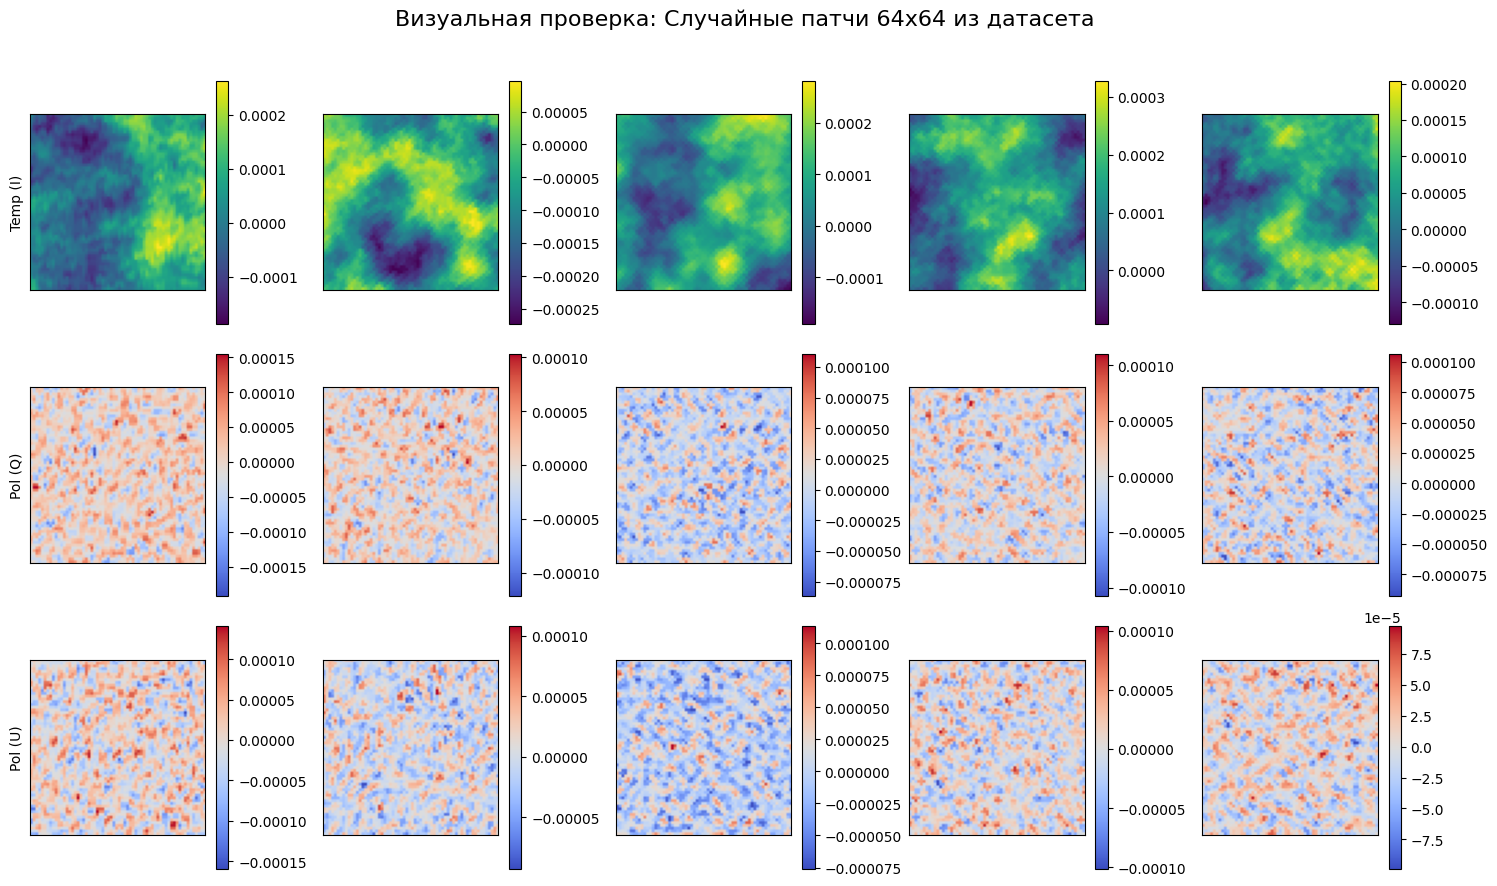

In [4]:
if 'dataset' in locals() and dataset is not None:
    print("Отображение одного батча данных для проверки...")
    sample_batch = next(iter(dataset))
    num_examples_to_show = min(sample_batch.shape[0], 5)

    fig, axs = plt.subplots(3, num_examples_to_show, figsize=(15, 9))
    plt.suptitle("Визуальная проверка: Случайные патчи 64x64 из датасета", fontsize=16)

    for i in range(num_examples_to_show):
        patch = sample_batch[i].numpy()

        # Денормализация для корректного отображения
        p_i = patch[:, :, 0] * stats['I']['std'] + stats['I']['mean']
        p_q = patch[:, :, 1] * stats['Q']['std'] + stats['Q']['mean']
        p_u = patch[:, :, 2] * stats['U']['std'] + stats['U']['mean']

        # Канал I (Температура)
        im_i = axs[0, i].imshow(p_i, cmap='viridis')
        if i == 0: axs[0, i].set_ylabel("Temp (I)")
        axs[0, i].set_xticks([]); axs[0, i].set_yticks([])
        fig.colorbar(im_i, ax=axs[0, i])

        # Канал Q (Поляризация)
        im_q = axs[1, i].imshow(p_q, cmap='coolwarm')
        if i == 0: axs[1, i].set_ylabel("Pol (Q)")
        axs[1, i].set_xticks([]); axs[1, i].set_yticks([])
        fig.colorbar(im_q, ax=axs[1, i])

        # Канал U (Поляризация)
        im_u = axs[2, i].imshow(p_u, cmap='coolwarm')
        if i == 0: axs[2, i].set_ylabel("Pol (U)")
        axs[2, i].set_xticks([]); axs[2, i].set_yticks([])
        fig.colorbar(im_u, ax=axs[2, i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Датасет не был загружен. Проверка невозможна.")

### Шаг 3: Создание модели VAE на основе U-Net

Это центральный этап нашего ноутбука, где мы определяем архитектуру нейронной сети. Наша цель — не просто сжать и восстановить изображение, а создать модель, способную изучить глубинную *сущность* "нормального" участка реликтового излучения. Для этого мы используем гибридную архитектуру: **вариационный автоэнкодер (VAE) с основой от U-Net**.

#### Архитектура "VAE + U-Net"

Модель состоит из трёх логических частей:

1.  **Энкодер (Сжимающий путь):** Эта часть модели последовательно анализирует входной патч 64x64, уменьшая его пространственное разрешение (через `MaxPooling`) и извлекая всё более сложные признаки (через `Conv2D`).
2.  **Латентное пространство:** В отличие от стандартного автоэнкодера, VAE сжимает данные не в простой вектор, а в вероятностное распределение, описываемое двумя векторами: средним значением (`z_mean`) и логарифмом дисперсии (`z_log_var`). Это заставляет модель изучать не конкретные пиксели, а более общие, фундаментальные свойства данных.
3.  **Декодер (Расширяющий путь):** Эта часть берёт точку из латентного пространства и пытается восстановить из неё исходный патч. Ключевой особенностью здесь являются **пропускающие соединения (skip connections)**, взятые из архитектуры U-Net. Они напрямую передают информацию о деталях с ранних слоёв энкодера на соответствующие слои декодера, что позволяет модели восстанавливать изображение с высокой точностью, избегая "размытости", характерной для классических VAE.

#### Ключевые архитектурные решения

В этой итерации мы внесли несколько критически важных изменений, чтобы заставить модель учиться "честно" и эффективно:

* **Шум в Skip Connections:** Мы намеренно добавляем небольшой гауссовский шум (`GaussianNoise`) в пропускающие соединения. Это "саботаж" против попыток модели "сжульничать" и просто скопировать входное изображение на выход. Шум заставляет декодер больше доверять осмысленной информации из латентного пространства, а не "шпаргалкам" от энкодера.
* **Значимый вес KL-дивергенции:** Мы отказались от "разогрева" KL-потерь и установили постоянный, значимый вес (`kl_beta = 1.0`). Это оказывает постоянное давление на модель, заставляя её с самой первой эпохи строить структурированное и гладкое латентное пространство — нашу будущую карту "нормальности".
* **Равные веса для каналов:** Мы убрали искусственное завышение весов для каналов поляризации (Q и U). Мощная архитектура U-Net должна справляться с восстановлением мелких деталей самостоятельно, и мы доверяем ей найти правильный баланс между всеми тремя каналами (I, Q, U) в процессе обучения.

В итоге, мы получаем сложную, но сбалансированную модель, специально спроектированную для нашей задачи: научиться настолько хорошо восстанавливать "нормальные" данные, чтобы любые отклонения от этой нормы (аномалии) приводили к высокой ошибке реконструкции.

In [5]:
# ==============================================================================
# Шаг 3: Создание модели VAE на основе U-Net (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# ==============================================================================

if 'dataset' in locals() and dataset is not None:
    # --- Гиперпараметры ---
    input_shape = (64, 64, 3)
    latent_dim = 32
    # ✨ НОВЫЙ ГИПЕРПАРАМЕТР: Уровень шума для skip-соединений
    skip_connection_noise = 0.1
    # ✨ НОВЫЙ ГИПЕРПАРАМЕТР: Вес для KL-дивергенции
    kl_weight = 1.0

    # --- U-Net VAE Архитектура ---

    # --- Энкодер (Сжимающий путь) ---
    encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")

    # Блок 1: 64 -> 32
    conv1 = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
    conv1 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Блок 2: 32 -> 16
    conv2 = layers.Conv2D(64, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Блок 3: 16 -> 8
    conv3 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # "Бутылочное горлышко" (Bottleneck)
    conv_bottle = layers.Conv2D(256, 3, activation="relu", padding="same")(pool3)
    conv_bottle = layers.Conv2D(256, 3, activation="relu", padding="same")(conv_bottle)

    # Латентное пространство
    flat_bottle = layers.Flatten()(conv_bottle)
    z_mean = layers.Dense(latent_dim, name="z_mean")(flat_bottle)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(flat_bottle)

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, conv1, conv2, conv3], name="encoder")
    print("--- Сводка по Энкодеру ---")
    encoder.summary()

    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]; dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    # --- Декодер (Расширяющий путь) ---
    latent_inputs = layers.Input(shape=(latent_dim,))
    skip1_input = layers.Input(shape=(64, 64, 32))
    skip2_input = layers.Input(shape=(32, 32, 64))
    skip3_input = layers.Input(shape=(16, 16, 128))

    # ✨ ИЗМЕНЕНИЕ: Добавляем шум к skip-соединениям, чтобы предотвратить "жульничество"
    noisy_skip1 = layers.GaussianNoise(skip_connection_noise)(skip1_input)
    noisy_skip2 = layers.GaussianNoise(skip_connection_noise)(skip2_input)
    noisy_skip3 = layers.GaussianNoise(skip_connection_noise)(skip3_input)

    # Начало декодера
    x = layers.Dense(8 * 8 * 256, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 256))(x)

    # Блок 1: 8 -> 16
    up1 = layers.UpSampling2D(size=(2, 2))(x)
    # ✨ ИЗМЕНЕНИЕ: Используем зашумленный тензор
    concat1 = layers.Concatenate(axis=-1)([up1, noisy_skip3])
    dec_conv1 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat1)
    dec_conv1 = layers.Conv2D(128, 3, activation="relu", padding="same")(dec_conv1)

    # Блок 2: 16 -> 32
    up2 = layers.UpSampling2D(size=(2, 2))(dec_conv1)
    # ✨ ИЗМЕНЕНИЕ: Используем зашумленный тензор
    concat2 = layers.Concatenate(axis=-1)([up2, noisy_skip2])
    dec_conv2 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat2)
    dec_conv2 = layers.Conv2D(64, 3, activation="relu", padding="same")(dec_conv2)

    # Блок 3: 32 -> 64
    up3 = layers.UpSampling2D(size=(2, 2))(dec_conv2)
    # ✨ ИЗМЕНЕНИЕ: Используем зашумленный тензор
    concat3 = layers.Concatenate(axis=-1)([up3, noisy_skip1])
    dec_conv3 = layers.Conv2D(32, 3, activation="relu", padding="same")(concat3)
    dec_conv3 = layers.Conv2D(32, 3, activation="relu", padding="same")(dec_conv3)

    # Финальный слой
    decoder_outputs = layers.Conv2D(3, 1, activation=None, padding="same")(dec_conv3)

    decoder = models.Model([latent_inputs, skip1_input, skip2_input, skip3_input], decoder_outputs, name="decoder")
    print("\n--- Сводка по Декодеру ---")
    decoder.summary()

    # --- Финальная модель VAE ---
    class VAE(models.Model):
        def __init__(self, encoder, decoder, kl_beta=1.0, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.kl_beta = tf.Variable(kl_beta, trainable=False, name="kl_beta")
            self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

        def call(self, inputs):
            z_mean, z_log_var, skip1, skip2, skip3 = self.encoder(inputs)
            z = Sampling()([z_mean, z_log_var])
            reconstruction = self.decoder([z, skip1, skip2, skip3])
            return reconstruction

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, skip1, skip2, skip3 = self.encoder(data)
                z = Sampling()([z_mean, z_log_var])
                reconstruction = self.decoder([z, skip1, skip2, skip3])

                reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
                loss_i = reconstruction_loss_fn(data[:, :, :, 0], reconstruction[:, :, :, 0])
                loss_q = reconstruction_loss_fn(data[:, :, :, 1], reconstruction[:, :, :, 1])
                loss_u = reconstruction_loss_fn(data[:, :, :, 2], reconstruction[:, :, :, 2])
                reconstruction_loss = loss_i + loss_q + loss_u
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss + self.kl_beta * kl_loss

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

    # ✨ ИЗМЕНЕНИЕ: Используем новый, более высокий вес для KL-дивергенции
    vae = VAE(encoder, decoder, kl_beta=kl_weight)
    print(f"\nМодель VAE на основе U-Net успешно создана с шумом на skip-соединениях ({skip_connection_noise}) и весом KL-потерь ({kl_weight}).")

else:
    print("Датасет не загружен. Пожалуйста, сначала запустите предыдущие шаги.")

--- Сводка по Энкодеру ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │    524,320 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │    524,320 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,220,896 (8.47 MB)

 Trainable params: 2,220,896 (8.47 MB)

 Non-trainable params: 0 (0.00 B)


--- Сводка по Декодеру ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16384)     │    540,672 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 256) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 16, 16,    │          0 │ -                 │
│ (InputLayer)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ reshape[0][0]     │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 16, 16,    │          0 │ input_layer_3[0]… │
│ (GaussianNoise)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 32, 32,    │          0 │ input_layer_2[0]… │
│ (GaussianNoise)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,315,363 (5.02 MB)

 Trainable params: 1,315,363 (5.02 MB)

 Non-trainable params: 0 (0.00 B)


Модель VAE на основе U-Net успешно создана с шумом на skip-соединениях (0.1) и весом KL-потерь (1.0).


### Шаг 4: Обучение модели

Запускаем процесс обучения. Мы используем все лучшие практики из предыдущих версий:
* **Сохранение всей модели:** `ModelCheckpoint` теперь сохраняет полную модель (`.keras`), включая состояние оптимизатора, что гарантирует корректное возобновление обучения.
* **Адаптивная скорость обучения:** `ReduceLROnPlateau` будет автоматически снижать скорость обучения, если прогресс остановится.
* **Пересчёт шагов:** `steps_per_epoch` вычислен на основе нового размера датасета (10 000 патчей).

In [ ]:
# ==============================================================================
# Шаг 4: Обучение модели (ИСПРАВЛЕННАЯ ВЕРСИЯ 2.0)
# ==============================================================================

if 'vae' in locals() and 'dataset' in locals() and dataset is not None:

    # --- 1. Настройка сохранения прогресса ---
    checkpoint_path = os.path.join(model_path, "training_v3_weights.weights.h5")
    print(f"Файл для сохранения весов модели: {checkpoint_path}")

    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path, save_weights_only=True, verbose=1,
        monitor='loss', mode='min', save_best_only=True
    )

    # --- 2. Настройка Callbacks ---
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    )

    # --- 3. Компиляция и построение модели ---
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

    # ✨ ИСПРАВЛЕНИЕ: Принудительно строим модель ПЕРЕД обучением.
    # Это создаёт все веса и решает проблему с их сохранением/загрузкой.
    vae.build((None,) + input_shape)

    # --- 4. Проверка и загрузка существующего прогресса ---
    if os.path.exists(checkpoint_path):
        print("\nНайден файл с весами. Загрузка...")
        try:
            vae.load_weights(checkpoint_path)
            print(" -> Веса успешно загружены. Обучение будет продолжено.")
        except Exception as e:
            print(f" -> ОШИБКА при загрузке весов: {e}. Обучение начнётся с нуля.")
    else:
        print("\nФайл с весами не найден. Обучение начнётся с нуля.")

    # --- 5. Запуск обучения ---
    total_patches = 10000
    steps_per_epoch = total_patches // BATCH_SIZE

    print("\nЗапуск обучения модели...")
    history = vae.fit(
        dataset,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        callbacks=[checkpoint_callback, reduce_lr_callback]
    )
    print("Обучение модели завершено.")

    # --- 6. Визуализация истории обучения ---
    if 'history' in locals() and history is not None:
        print("\nПостроение графика истории обучения...")
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(history.history['loss'], label='Общая ошибка (Total Loss)')
        plt.plot(history.history['reconstruction_loss'], label='Ошибка реконструкции (Reconstruction Loss)')
        plt.title('История обучения: Основные метрики', fontsize=16)
        plt.ylabel('Ошибка', fontsize=12)
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.yscale('log')

        plt.subplot(2, 1, 2)
        plt.plot(history.history['kl_loss'], label='KL-расхождение (KL Loss)', color='green')
        plt.title('KL-расхождение', fontsize=16)
        plt.xlabel('Эпоха', fontsize=12)
        plt.ylabel('Значение KL Loss', fontsize=12)
        plt.legend()
        plt.grid(True, which="both", ls="--")

        plt.tight_layout()
        plt.show()
    else:
        print("\nИстория обучения не найдена для визуализации.")

else:
    print("Модель или датасет не найдены.")

### Шаг 5: Оценка качества реконструкции

После завершения обучения (или загрузки лучшей контрольной точки) мы визуально оцениваем, насколько хорошо модель научилась восстанавливать патчи. Мы сравниваем оригинальные изображения из датасета с их реконструкциями, созданными моделью, для всех трёх каналов.

Загрузка лучших сохранённых весов из: /content/drive/My Drive/CosmicLegacy/models_v3/training_v3_weights.weights.h5
 -> Веса успешно загружены в модель для оценки.

Отображение оригинальных, восстановленных патчей и карты остатков...


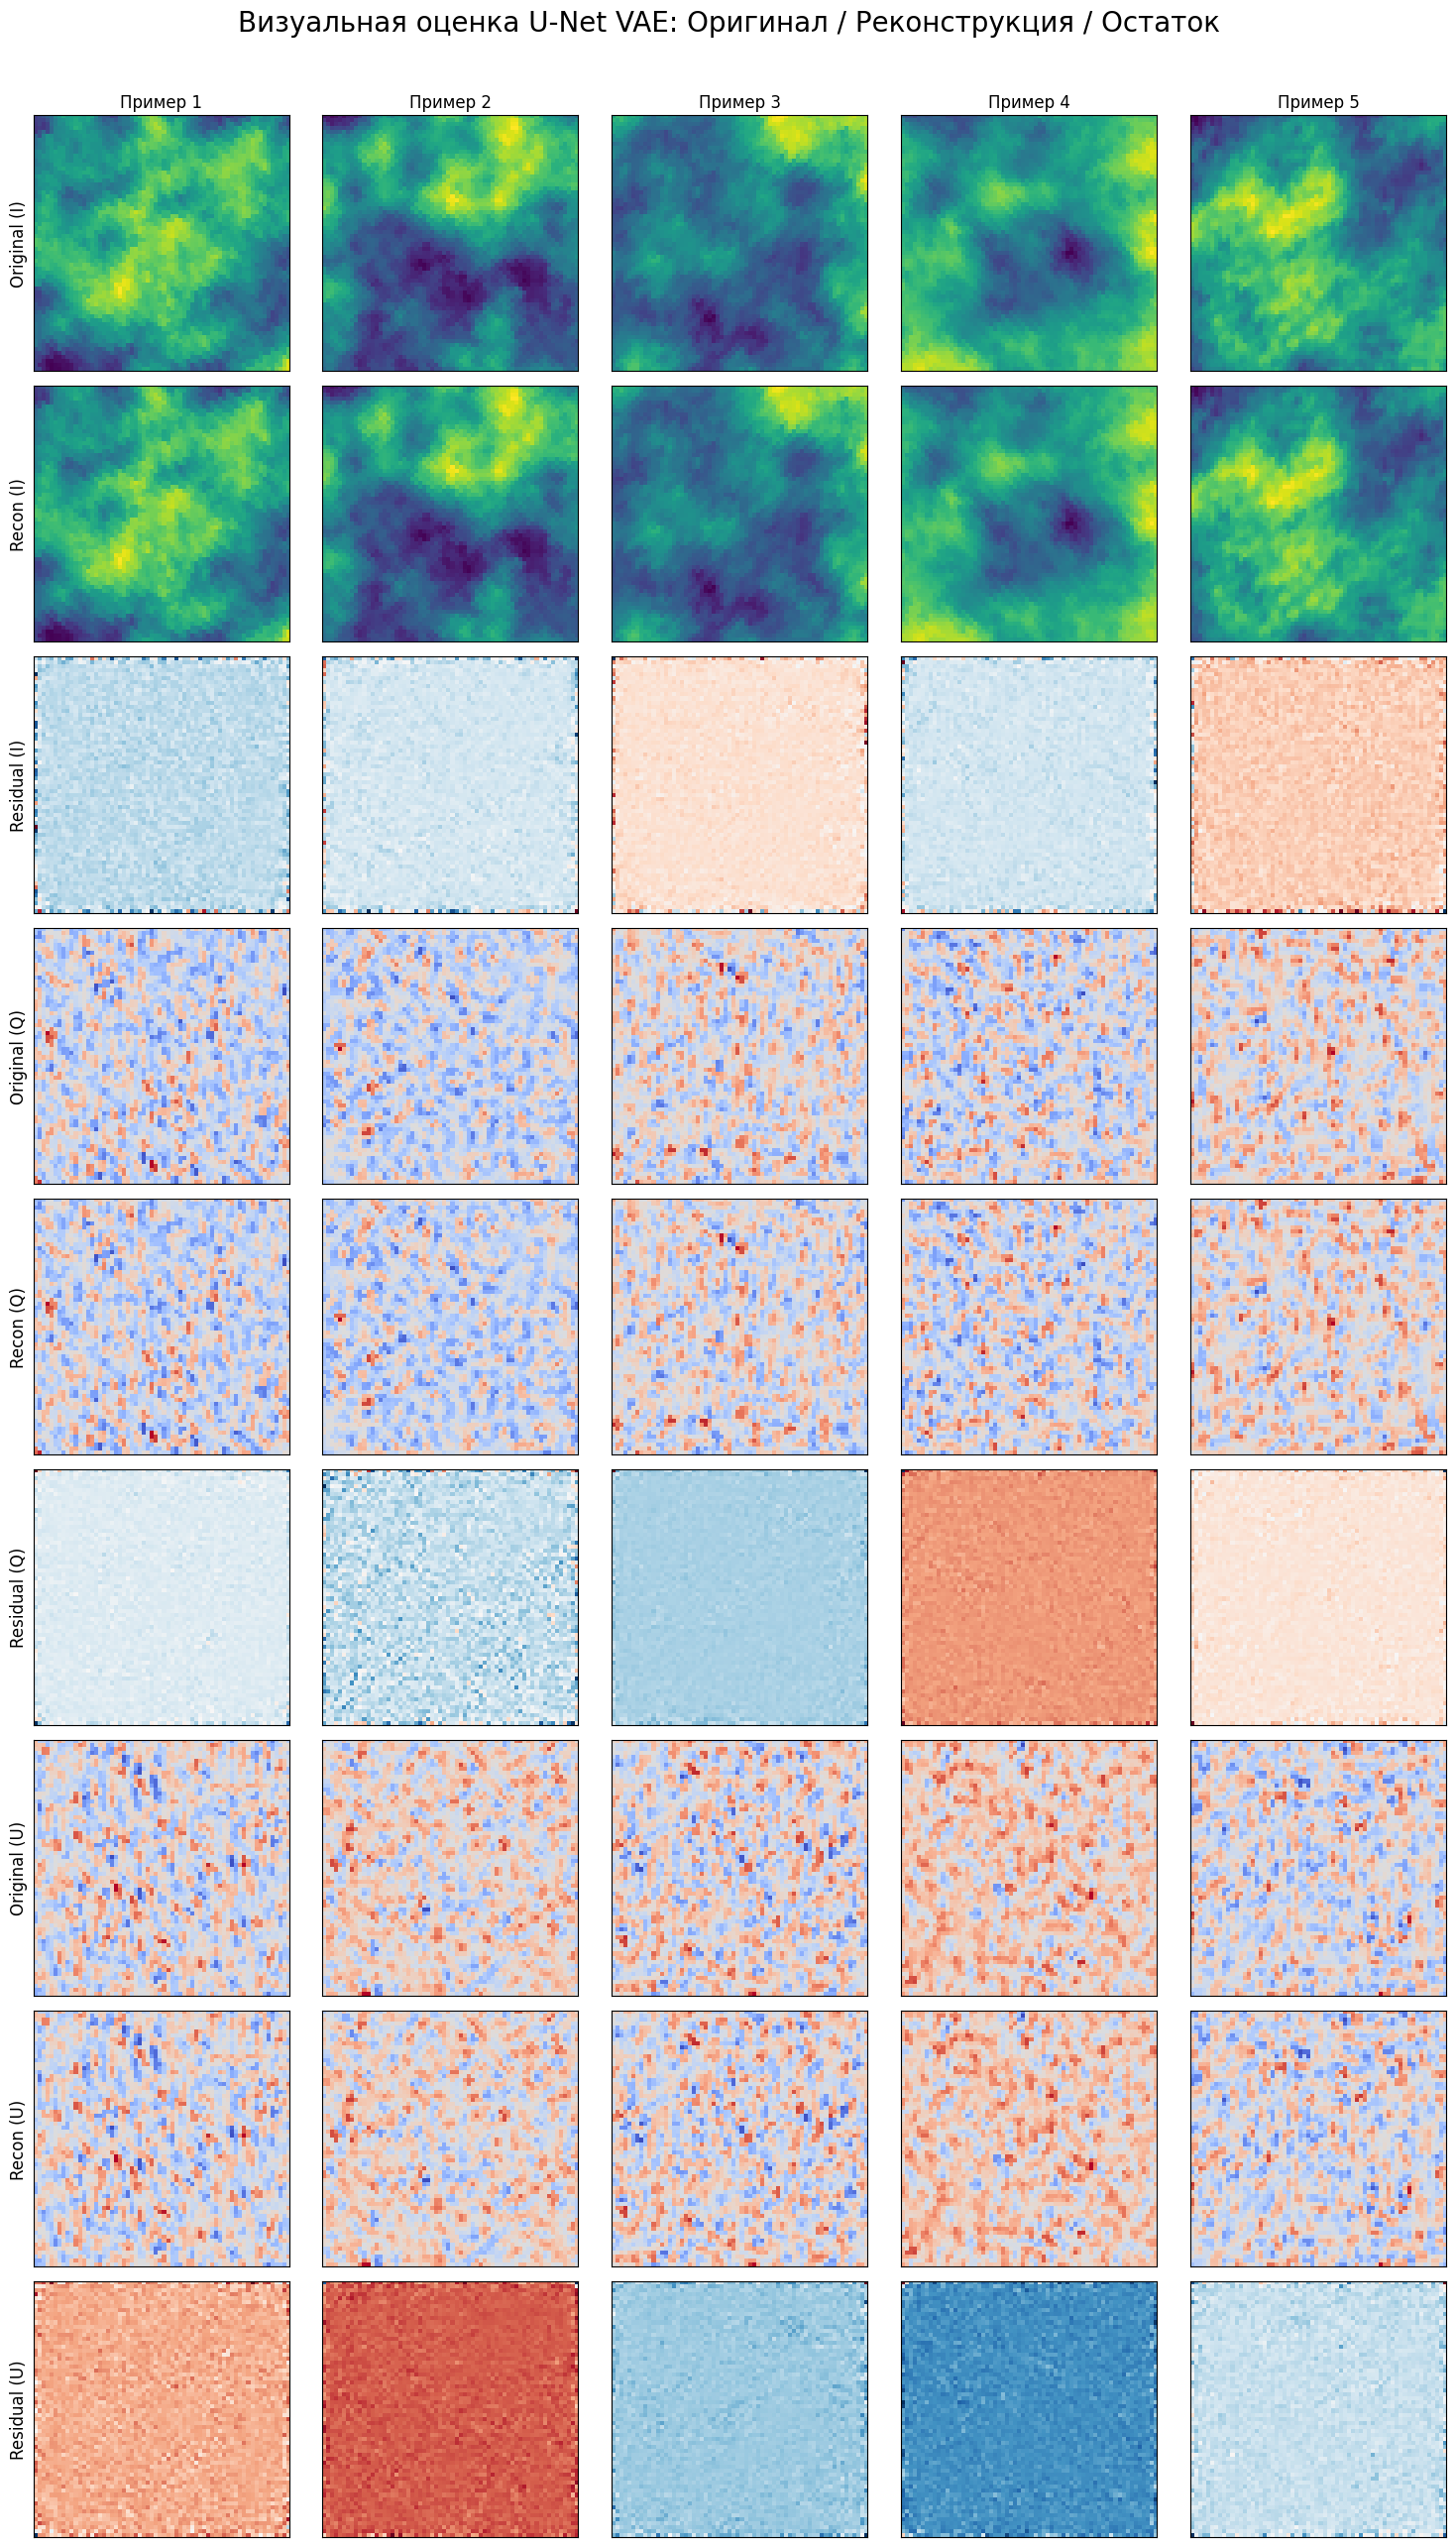

In [ ]:
# ==============================================================================
# Шаг 5: Оценка качества реконструкции (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# ==============================================================================

if 'vae' in locals() and 'dataset' in locals() and dataset is not None and 'stats' in locals() and stats is not None:

    # --- 1. Загрузка лучших весов в СУЩЕСТВУЮЩУЮ модель ---
    # Нет необходимости пересоздавать модель. Мы просто загружаем лучшие веса
    # в тот же объект 'vae', который мы обучали.
    checkpoint_path = os.path.join(model_path, "training_v3_weights.weights.h5")
    if os.path.exists(checkpoint_path):
        print(f"Загрузка лучших сохранённых весов из: {checkpoint_path}")
        try:
            # Загружаем веса в нашу основную модель vae
            vae.load_weights(checkpoint_path)
            print(" -> Веса успешно загружены в модель для оценки.")
            model_to_evaluate = vae
        except Exception as e:
            print(f" -> ОШИБКА при загрузке весов: {e}.")
            model_to_evaluate = None
    else:
        print("ОШИБКА: Файл с весами не найден. Оценка невозможна.")
        model_to_evaluate = None

    # --- 2. Получение и реконструкция батча ---
    if model_to_evaluate:
        # Берём один батч из датасета для примера
        sample_batch = next(iter(dataset))
        num_examples_to_show = min(sample_batch.shape[0], 5)
        original_patches = sample_batch[:num_examples_to_show]

        # Получаем реконструкции
        reconstructed_patches = model_to_evaluate.predict(original_patches, verbose=0)

        # --- 3. Визуализация с картой остатков ---
        print("\nОтображение оригинальных, восстановленных патчей и карты остатков...")
        # ✨ ИЗМЕНЕНИЕ: Добавили 3 ряда для карты остатков
        fig, axs = plt.subplots(9, num_examples_to_show, figsize=(15, 27))
        plt.suptitle("Визуальная оценка U-Net VAE: Оригинал / Реконструкция / Остаток", fontsize=20)

        for i in range(num_examples_to_show):
            original_patch = original_patches[i].numpy()
            reconstructed_patch = reconstructed_patches[i]

            # Денормализация для корректного отображения
            p_i_orig = original_patch[:, :, 0] * stats['I']['std'] + stats['I']['mean']
            p_i_recon = reconstructed_patch[:, :, 0] * stats['I']['std'] + stats['I']['mean']
            p_q_orig = original_patch[:, :, 1] * stats['Q']['std'] + stats['Q']['mean']
            p_q_recon = reconstructed_patch[:, :, 1] * stats['Q']['std'] + stats['Q']['mean']
            p_u_orig = original_patch[:, :, 2] * stats['U']['std'] + stats['U']['mean']
            p_u_recon = reconstructed_patch[:, :, 2] * stats['U']['std'] + stats['U']['mean']

            # ✨ НОВОЕ: Расчёт карты остатков (разницы)
            residual_i = p_i_orig - p_i_recon
            residual_q = p_q_orig - p_q_recon
            residual_u = p_u_orig - p_u_recon

            # Отображение I (Температура)
            axs[0, i].imshow(p_i_orig, cmap='viridis'); axs[0, i].set_title(f"Пример {i+1}")
            if i == 0: axs[0, i].set_ylabel("Original (I)", fontsize=12)
            axs[1, i].imshow(p_i_recon, cmap='viridis')
            if i == 0: axs[1, i].set_ylabel("Recon (I)", fontsize=12)
            axs[2, i].imshow(residual_i, cmap='RdBu_r'); # Карта разницы
            if i == 0: axs[2, i].set_ylabel("Residual (I)", fontsize=12)

            # Отображение Q (Поляризация)
            axs[3, i].imshow(p_q_orig, cmap='coolwarm')
            if i == 0: axs[3, i].set_ylabel("Original (Q)", fontsize=12)
            axs[4, i].imshow(p_q_recon, cmap='coolwarm')
            if i == 0: axs[4, i].set_ylabel("Recon (Q)", fontsize=12)
            axs[5, i].imshow(residual_q, cmap='RdBu_r');
            if i == 0: axs[5, i].set_ylabel("Residual (Q)", fontsize=12)

            # Отображение U (Поляризация)
            axs[6, i].imshow(p_u_orig, cmap='coolwarm')
            if i == 0: axs[6, i].set_ylabel("Original (U)", fontsize=12)
            axs[7, i].imshow(p_u_recon, cmap='coolwarm')
            if i == 0: axs[7, i].set_ylabel("Recon (U)", fontsize=12)
            axs[8, i].imshow(residual_u, cmap='RdBu_r');
            if i == 0: axs[8, i].set_ylabel("Residual (U)", fontsize=12)

            for j in range(9):
                axs[j, i].set_xticks([]); axs[j, i].set_yticks([])

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
else:
    print("Модель или датасет не найдены. Пожалуйста, сначала запустите предыдущие шаги.")

### Шаг 6: Сохранение финальных моделей

В завершение мы сохраняем финальные, обученные веса энкодера и декодера в отдельные файлы. Это позволит нам легко загрузить их в следующем ноутбуке для сканирования неба.

In [ ]:
# ==============================================================================
# Шаг 6: Сохранение финальных моделей (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# ==============================================================================

if 'vae' in locals():
    # --- 1. Убеждаемся, что в модель загружены лучшие веса ---
    # ModelCheckpoint уже сохранил лучшие веса во время обучения.
    # Загрузим их в нашу основную модель 'vae' для чистоты эксперимента,
    # на случай если обучение было прервано после пика производительности.
    checkpoint_path = os.path.join(model_path, "training_v3_weights.weights.h5")
    if os.path.exists(checkpoint_path):
        print(f"Загрузка лучших весов из '{checkpoint_path}' в рабочую модель...")
        try:
            vae.load_weights(checkpoint_path)
            print(" -> Веса успешно загружены.")

            # --- 2. Сохранение отдельных моделей ---
            # Теперь мы сохраняем компоненты прямо из нашего обученного объекта 'vae'.
            encoder_path = os.path.join(model_path, 'final_encoder_v3.keras')
            decoder_path = os.path.join(model_path, 'final_decoder_v3.keras')

            # Используем vae.encoder и vae.decoder напрямую
            vae.encoder.save(encoder_path)
            vae.decoder.save(decoder_path)

            print(f"\n✅ Финальный энкодер сохранён в: {encoder_path}")
            print(f"✅ Финальный декодер сохранён в: {decoder_path}")

        except Exception as e:
            print(f" -> ОШИБКА при загрузке весов или сохранении моделей: {e}")
    else:
        print("ОШИБКА: Файл с весами не найден, сохранение невозможно.")
else:
    print("Модель 'vae' не найдена в памяти. Запустите предыдущие шаги.")

Загрузка лучших весов из '/content/drive/My Drive/CosmicLegacy/models_v3/training_v3_weights.weights.h5' в рабочую модель...
 -> Веса успешно загружены.

✅ Финальный энкодер сохранён в: /content/drive/My Drive/CosmicLegacy/models_v3/final_encoder_v3.keras
✅ Финальный декодер сохранён в: /content/drive/My Drive/CosmicLegacy/models_v3/final_decoder_v3.keras
